# Digitre

#### December 2016

In [25]:
# Standard library
import datetime

# Third party libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import helpers as helpers

In [85]:
import imp
imp.reload(helpers)

<module 'helpers' from '/home/luis/Documents/digitre/digitre/helpers.py'>

In [86]:
# Latest update
str(datetime.datetime.now())

'2016-12-14 22:42:15.947056'

In [87]:
b64_img_str = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAARSElEQVR4Xu2dW8h1RR3GH8kS0jQvuhAtO2FEdLyQSMvCirDUSunCCEvrIiI60EFvsiKKgg4SREhZiYVEZlkIGh2pCC862UVFYqZhEGEn9MYofjmj4/rW/t6ZWXv22mvWs+Dlfb/9zcyaef7z7P9hZv5zhPwYASOwEYEjjI0RMAKbETBBPDuMwGEQMEE8PYyACeI5YATqELAGqcPNtVaCgAmyEkF7mHUImCB1uLnWShAwQVYiaA+zDgETpA4311oJAibISgTtYdYhYILU4eZaK0HABFmJoD3MOgRMkDrcXGslCJggKxG0h1mHgAlSh5trrQQBE2QlgvYw6xAwQepwc62VIGCCrETQHmYdAiZIHW6utRIETJCVCNrDrEPABKnDzbVWgoAJshJBe5h1CJggdbi51koQMEFWImgPsw4BE6QON9daCQImyEoE7WHWIWCC1OHmWitBwARZiaA9zDoETJA63FxrJQiYICsRtIdZh4AJUoeba60EARNkJYL2MOsQMEHqcHOtlSBggswn6MdLOlnSoyU9SxKy+G/SnfTf/5B03Ib/S8vFv/n9d0l3S/rSfENc/ptNkN3LEGK8X9KFBa/+oaQzCspTNNb5paRnF9Z18YCACbKbqYCWYIK/UtKZkm6XdHrBq2sIwjvQUDzXSPpd0FCplkFjRW1zWyAVmsePCdJ8DmA2oSVeKOmJko4Nb4yT/ccFJKkhSMkAY/t3SLpCEr9tmoVvjxIgXfZgBDChvjgwiX4l6ZmhKv4E39oQJpckuyII7+FB29k0M0EOnu0FJdAU50i6SNItA+0wnODx3xDnaknHHPAezB7MtJyHftT4K/gpmFwQI9Z/laRv5Ly01zL2QaZJlkn7NkkXS3psaOonkk4baIebJZ2avAoT5kpJnwrRpmm9eGhtAgCXFTYIYU+S9CRJfww/NPHN0MfC5vopboLUyxIHmAmE6TTUENF0ir/vlPQ3ST8IPy2/ldEg/JQ890l6dzD70FZoERPEJlbJHDqkLJPoX8GUSv2KWBByPF3SBZJ+2kBTTOr8SOVLk9DzXSbI/QhYg9RNM/yMz4eqUUuM+RlEsQi3LuF5u6RzBx21ibUEye1ZHzGtbpR0pCRMJxxb/n6apOuDeYJ2wZxa0mOCjEjLGqR8CkfTKmKHQ85ztqRvlze3NzVMEBNk8mTE+f1+YlpFkhCmZWFwyY8JYoJMnr/DSYRp9RhJL0tCo5NfMlMDH5D0AvsgD0XAJlbZbBz7lr1J0kfKmtnL0n+WdI8kfsddxXbS91JU+9upXs2QoekYN1K+aIHBhq3OHmuQMjh7JcjQvMJ0ZIPliWXw9FfaBCmTaa8EsXm1YR6YICbI2KInqKzevAIEE6SMIGMbATFP+HyJD4uevw0LntE5t3mVSNIEKZvWvREk3U+Wnk2x9gjzwgQpI8jQBzkqhERfvoDNiMORvl7SF8KH6e7jR3Ww6Fkm1cOUNkHKoBwS5ARJTwn7r9iY+Ouy5mYtzbmV5yU9iLuP2RHAmRA/9kGK5wCT5xeh1j+D9iAdD5PtcWGH7+UL0CYcCYbQ35H0CEkQ/ZRwtmVJJC8WYGkFa5BSxO4/b87kitvb4wnCNM3OPmuT1LRKt+hfK+n8cjj6rmGC1MkXU+udkv4UjteOaZPvhvPcTMJ9SqXDlnx2HvOkBFn9+fOxqWCC1BGEWs+QdNXgyO1Qm1CO8Olfw5YNUunE46z1b66vScYV8l9xjuVWSQ8Pfgj9QrP4GSBggkybEiRtQJuw2DamTWh9mLCBg1RvmMkRjuZhOurfhKPB05DotLYJsh3BjmmT2PLwKO5cDj195EAXmuM5SSK7d6w9c8nhpoAJsh2C0EqqTWIKID5Pk8YNTTDS/3C2vXXki75x0OvfSZIJonGk+YE4++QjbU8iW2jJBNkCiCNNYM8TEmYb+RPCt3UkR+rQpyk/Wzr1pBmKCRnSFfMlb5NpIzn7IDvBNX0J394syH144NCPESV16kkqx4Glqd/uJMwmuV2aKwuSsGLOZ1Pb3zmgu3yhNcju0B6aYFF7pEQZc+px6HGuax7eSdSK32R3R94sCJLHi+O1XhQ8AFUTpGbaTauziSibnHo+ryXJ2OZKomj4PC2zO05DaI9qmyDzCSPHqUe7/FzSkyV9ThI+Q+6zKWqF2YbZ5ScDARMkA6QdFBk69bwSYpBxnb1e6TYWtqIf5DccLmqFaeXNiJlCNUEygdphMSb3JZLeG9459FHYYPieA1bkU9PKUasJwjNBJoDXuGoMzaYLjWmomMjUmPOeOuaxi45aVQrLBKkEbkfV0ASsdHMbVSQHr46kgSA48OlDeJgLcJBtvNWK/+dvR60KBWeCFAI2Q3EWHD8m6SUbTK50Fy6OOSv38WFjJDJGGy313PwMkD/4ShNkVvizX47ZRHh27LIeHHZW6zmw9aOR699Y82AX70GOfXZn1lTQBFmWtFOTi56jLUgTyu1VXL/wh7DXyo75luRqgmwJyB02g4/BFhGIMZZR/meSnhvuSHQChomCMUEmAjhDdcwt1jFYH9n0QJKnBgJ5zWOCkEyQCeDNWDU9V552gzUTIl73Bi3iqNVEIZkgEwGcsXq6hX2sGz4ItQXhmCBbAHGGJoaLgdy2i7+RPjG65ejVBAGZIBPAm7Hq2C7dtDsxusVlo9fMnChiRpimv9oEmY7hLltAc7DF5I0hpJueLY8LhGPRLcwxVtytTQqlZYIUAjZj8ZiLi/PucasJi4DxbPnzw7rIpugWCRteZ5KUSdAEKcNrrtLDbI4QA9kRseKJDvmm6Fbcx8VqPNvl/WQiYIJkAjVjMQ43XRfenxIjapHhAaghSdJNjjTjDIoFwjRBCsCaoejY1vU0E8onNuS0Yu8VxDor2eQYu/8VSa+dYSyLfKUJst9iG9u6jhbhc34Ocrrj7bW/l3RXyIOFWQaxWufi2m9kM3tngmQCteNiaIDLJL068TPi1nX8CBz23Odrks5LCqfHd9Eyt+c2tMZyJsh+SR1ifCgxgYZpS2u2rqd3oA+z0JNUG5/EzwYETJD9mRpohU+G7pARnjvKh9GqWgd7050mvI7EEHNmnN8fCYz0xATZD/Gk3/L0iINPZB/hiVpk6hUFRLc+mGShjyP3hZ2HmQMmyPwEGYtUkQWRuw95SHD9vgnZFdMRXhpSoKafOT+vCTI/Cw7Tg01JFkjvc0MgxkHRqtwBpmYcdfBJPh40S24bqypnDTKfuOO+Kq5yiyviMVLFIacW2Q/TS0hT8602tel86O3ozSbIjoAevIbJzx3lkGQbkaqSUbCZMWoP/o57tzwXRlA0KCVTa3pZwrhEqo4PuatocVuRqtzexa0oQ2I6mmWC5M6hJuWGGUlY3eYqgtTUmRqpyu04Tj+mXbrz12aWCZI7f7ZebiyNaKtIVU7nxw5cvUXSZ3Iqr6mMTaz20k5vlh2aU/EOdaJLu8w+Mlx3Ycfv0WHRsD0iC3qDCdJWWNj7Fw6uP0sPO/H/c1xkk0az0u3wXjQczAcTpB1BmITcLDt2/Vnubtx2vZNuCbuB70tewtkS+uYnIGCCtJkKmDCsWr900Dw7cXHEa+8c3GZvh4uGtO3bp6xBtjnHDmkLrfGuZDdumiOXwruKUuUMcuiHUIeFSsK9fqxBtj4H0shQ3I3LSyJJyDqyb9cu3ymJHzIxYgqSJZ7ffkyQrc6B4RaOdDcuL2Jf1WsyTgButVMZjRE5O3lQzo56Aoh9kIxZlFHky5IuSMqlaxxErdhasq0NhxndyS6Spi/lSO49kq7y5sUH8TNBsufSaMF0wyE7Y2+VdEJYIb9W0tUzhXFzR/WKEIY+NVzAQ71vSTont4Hey5kgdRKOxLhYUprILbYGOc6va3qntdgbdpukNKnDSWGv2D5qvJ2Cw8tMkHLIsdkJh6bXoQ1XyJdkx980khqo9mhvOZp7XsMEKRcQoVCyqZ8+2Im7raOx5T2aVoOFQfL9ps9nJb15WrN91DZByuSYZi2M4ds0kdu2jsaW9Wpa6eGCIVtPnO0kYGqClE2u6yWdnVSBJJhcV2Ymcit7225KpwuG6b4snw+xD1I0AyEC6wYsrKXRKnyRpV91xhaYIyWdliCyJD+qSJAlha1B8tFiEj0s+B5Li1YdNMqxfVnOdmINctC8eeD/UzMk3V/Vyym8sQNUJogJkk2Q4TcsJOnpDnITZMNUsImVx5GxCfRRSZfkVd/7UiaICTJpkqJBzh200NPhot7HVy18a5A86Hr/hu19fHlSHillguRB1/sE6n18eVI2Qapx6n0C9T6+asFbg+RB1/sE6n18eVK2BqnGqXcntvfxVQveGiQPut6/YXsfX56UrUGqcep9AlmDeB2kmhxUNEEmwbfcyjax8mTXO0F6H1+elG1iVePU+wSyiWUTq5ocazCxev8CqBa+Taw86Hr/hu19fHlStolVjVPv37AmiE2sanLYxJoE3bIr28TKk1/vGuStks6TFG/ABZWetvPnSdkmVjVOvRIkzRB5++C8fS/HiauFTkVrkDz4eiMIKUdJFofWSFOnpuftnfbHBMljx4aV9Msl4dwu6TlL0ptCtnn6nd6XyJflseE+k/8M7lVc0hi32ldrkDw4ub7gukHRpWRBj2YUWSHJfUVy6vikOYUjWbjoh/Hu8tbdPCnMUMoEyQOdSXb3SBZ0bmTa54mEaXhRMKPiSG+WxHUH8UlTpy45Q2SeJAtLmSD5gC0pCzqE5oZdbr6KBNhEkDsWnjo1X4IVJU2QfNCWsJgGIUiFym1X8Ybd4dUMjJg7FLn+mczu3Ljru0A2zAMTJJ8g+xjJwleAEGR+ZA2DfLrxSSNSqRZhfeMKSTfkD329JU2QfNmPaZCvS/p0fhNbKYmWIER75sC3SO9FHJIELYKmQGPss8+0FYC22YgJko9mejcItbgq4Ojwrd3aRGHdIoZoIQjP0LfYNBI0BtqPi3/8FCJgguQDll71nN6jwU2xXFk25cGpxlSCCPwgF0ym40NGRz4bXi095ltw1+ApSUdYq4EcrQk8Zex7XdcEKRPP2D0aN0oidMriGngyGY8LzTKJ4998FCc+N+EeFcjwyEHYdVOPxkyooRYhcsVtu5CWvtqcKpPvIaVNkDIA+SbHVGHS823Nt/xfQhNnjJg+OWbQ2MTf1CuiTycm/0mI9nuBEPTLhCiT54GlTZADITqkAJEjHPaUEBSqJUhJD6KZxWo3DjeawuZTCYKFZU2QQsBC8fRmWLREDUFS82voO4z1ivd8NYRnrSnq5FZcywQphuyBCoRNLwzRpBqCpOYXPsy9QRuk0Sa0A//mx5qiXlbVNU2Qauj+XxGf5MWSjpFEJIqHiTz29/BNcdKjDawRpsmhWW0TpBm0brgHBEyQHqToMTRDwARpBq0b7gEBE6QHKXoMzRAwQZpB64Z7QMAE6UGKHkMzBEyQZtC64R4QMEF6kKLH0AwBE6QZtG64BwRMkB6k6DE0Q8AEaQatG+4BAROkByl6DM0QMEGaQeuGe0DABOlBih5DMwRMkGbQuuEeEDBBepCix9AMAROkGbRuuAcETJAepOgxNEPABGkGrRvuAQETpAcpegzNEDBBmkHrhntAwATpQYoeQzMETJBm0LrhHhAwQXqQosfQDAETpBm0brgHBEyQHqToMTRDwARpBq0b7gEBE6QHKXoMzRAwQZpB64Z7QMAE6UGKHkMzBEyQZtC64R4QMEF6kKLH0AwBE6QZtG64BwRMkB6k6DE0Q8AEaQatG+4BAROkByl6DM0QMEGaQeuGe0DABOlBih5DMwRMkGbQuuEeEDBBepCix9AMAROkGbRuuAcETJAepOgxNEPABGkGrRvuAQETpAcpegzNEDBBmkHrhntAwATpQYoeQzMETJBm0LrhHhAwQXqQosfQDAETpBm0brgHBP4HUN4n9nkYL2kAAAAASUVORK5CYII="
digit = helpers.b64_str_to_np(b64_img_str)

Dimensions of numpy ndarray:  (200, 200, 4)


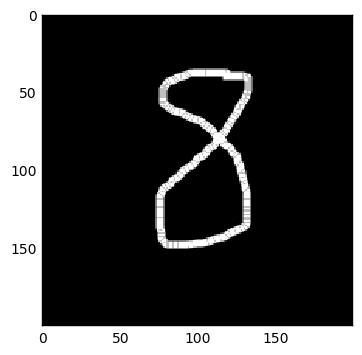

In [88]:
plt.imshow(digit, cmap = 'gray', interpolation = 'none')

In [89]:
digit = helpers.crop_img(digit)

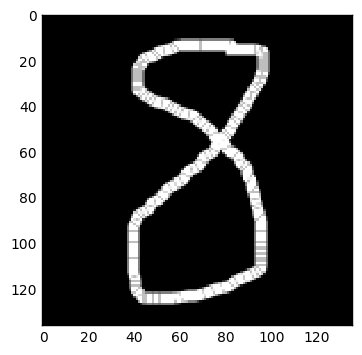

In [90]:
plt.imshow(digit, cmap = 'gray', interpolation = 'none')

In [91]:
digit = helpers.resize_img(digit)

In [92]:
digit.shape

(28, 28)

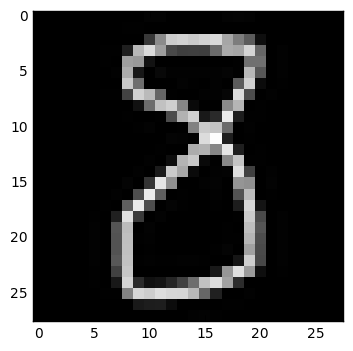

In [93]:
plt.imshow(digit, cmap = 'gray', interpolation = 'none')

In [94]:
digit = helpers.flatten_img(digit)
digit.shape

(784,)